# Notebook: Preprocesamiento de Datos de Beam (CHARM)

En esta sección vamos a leer, limpiar y concatenar los archivos CSV del beam para obtener un único DataFrame con:
- **Time**: timestamp (`datetime64[ns]`)
- **TID**: dosis acumulada (Gy)
- **HEH**: conteo acumulado de hadrones
- **N1MeV**: conteo acumulado de neutrones > 1 MeV

Nos interesa extraer:
- La columna `Time` (convertirla a `datetime64[ns]`).
- `TID_RAW1` renombrada como `TID`.
- `HEH` (ya en conteo acumulado).
- `N1MeV_RAW0` renombrada como `N1MeV`.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# 1) Buscar todos los archivos CSV de beam
beam_paths = glob.glob(os.path.join("..", "0_raw", "Campaign2", "beam", "*merged.csv"), recursive=True)
if not beam_paths:
    raise FileNotFoundError("No se encontraron archivos '*.csv' en las rutas esperadas.")

beam_paths

['..\\0_raw\\Campaign2\\beam\\merged.csv']

-------------------------------------------------------------
==== ..\0_raw\Campaign2\beam\merged.csv ====


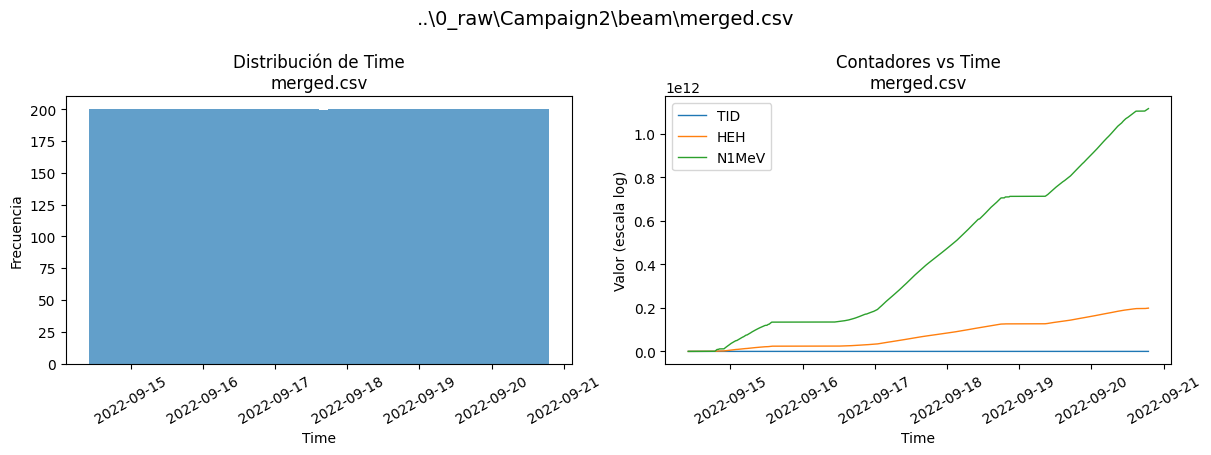

Cargado: ..\0_raw\Campaign2\beam\merged.csv  (run_group=run_1, 9999 filas)
-------------------------------------------------------------
#========================= Comprobación de time stamps espaciados ===========================#

=== Run 1 (1) ===
Duplicados en Time: 0

Intervalos entre lecturas (segundos) — estadísticos:
count    9.998000e+03
mean     5.508541e+01
std      1.673252e-07
min      5.508541e+01
1%       5.508541e+01
5%       5.508541e+01
10%      5.508541e+01
50%      5.508541e+01
90%      5.508541e+01
95%      5.508541e+01
99%      5.508541e+01
max      5.508541e+01
Name: Time, dtype: float64

Saltos detectados (diff > 55.09 s): 2226 ocurrencias
---> Gap en 10 → intervalo = 55.09 s
---> Gap en 21 → intervalo = 55.09 s
---> Gap en 24 → intervalo = 55.09 s
---> Gap en 27 → intervalo = 55.09 s
---> Gap en 29 → intervalo = 55.09 s

Cinco saltos más grandes:
---> Gap en 10 → intervalo = 55.09 s
---> Gap en 21 → intervalo = 55.09 s
---> Gap en 24 → intervalo = 55.09 s
---> 

In [4]:
# Función para cargar un solo CSV, asignar run_group, verificar monotonía y graficar
def load_and_check_run(path, run_id, plot=False, title=None):
    """
    Carga un CSV de beam, extrae columnas relevantes y asigna un run_group.
    Verifica que TID, HEH y N1MeV sean monotonamente crecientes dentro de este run.
    Si plot=True, dibuja dos gráficos:
      • Izquierda: distribución de timestamps (histograma).
      • Derecha: TID, HEH y N1MeV vs Time (escala log en el eje Y).
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # 1) Leer y renombrar columnas
    df_run = pd.read_csv(path, usecols=["Time", "TID_RAW1", "HEH", "N1MeV_RAW0"])
    df_run["Time"] = pd.to_datetime(df_run["Time"])
    df_run = df_run.rename(columns={"TID_RAW1": "TID", "N1MeV_RAW0": "N1MeV"})
    df_run = df_run[["Time", "TID", "HEH", "N1MeV"]].sort_values("Time").reset_index(drop=True)

    # 2) Asignar identificador de run
    df_run["run_group"] = int(run_id)

    # 3) Verificar monotonía sin interrumpir la ejecución
    if not df_run["TID"].is_monotonic_increasing:
        print(f"ERROR: TID no es monotónico en {path}")
    if not df_run["HEH"].is_monotonic_increasing:
        print(f"ERROR: HEH no es monotónico en {path}")
    if not df_run["N1MeV"].is_monotonic_increasing:
        print(f"ERROR: N1MeV no es monotónico en {path}")

    # 4) Gráficos si plot=True
    if plot:
        # Preparar figura con 1 fila, 2 columnas
        fig, (ax_time, ax_vars) = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

        # ---- Izquierda: histograma de los timestamps (frecuencia de lecturas en el tiempo) ----
        ax_time.hist(df_run["Time"].values.astype("datetime64[s]"), bins=50, color="tab:blue", alpha=0.7)
        ax_time.set_title(f"Distribución de Time\n{os.path.basename(path)}")
        ax_time.set_xlabel("Time")
        ax_time.set_ylabel("Frecuencia")
        for tl in ax_time.get_xticklabels():
            tl.set_rotation(30)

        # ---- Derecha: TID, HEH y N1MeV vs Time (escala log en Y) ----
        ax_vars.plot(df_run["Time"], df_run["TID"],   label="TID",   linewidth=1)
        ax_vars.plot(df_run["Time"], df_run["HEH"],   label="HEH",   linewidth=1)
        ax_vars.plot(df_run["Time"], df_run["N1MeV"], label="N1MeV", linewidth=1)
        #ax_vars.set_yscale("log")
        ax_vars.set_title(f"Contadores vs Time\n{os.path.basename(path)}")
        ax_vars.set_xlabel("Time")
        ax_vars.set_ylabel("Valor (escala log)")
        ax_vars.legend(loc="upper left")
        for tl in ax_vars.get_xticklabels():
            tl.set_rotation(30)

        # aqui poner el titulo a la figura completa
        if title:
            # Ajusta 'y' para que el título no choque con los subplots
            fig.suptitle(title, fontsize=14, y=1.1)

        plt.show()


    return df_run


# =======================================================#
# Leer todos los runs, chequear y almacenar en lista
plot_variables = True
dfs_runs = []
print("-------------------------------------------------------------")
for idx, path in enumerate(beam_paths, start=1):
    # try:
    #     df_run = load_and_check_run(path, idx, plot=plot_variables)
    #     dfs_runs.append(df_run)
    #     print(f"Cargado y verificado: {path}  (run_group=run_{idx}, {len(df_run)} filas)")
    # except Exception as e:
    #     print(f"Posible error en {path}: {e}")
    #     # lo almacenaré de todos modos, pues aun no he conversado esto de monotonia
    #     # podría ser producto de ruido y is_monotonic_inreasing sea demasiado simple

    # codigo temporal, importando todo:
    print(f"==== {path} ====")
    df_run = load_and_check_run(path, idx, plot=plot_variables, title=path)
    print(f"Cargado: {path}  (run_group=run_{idx}, {len(df_run)} filas)")
    dfs_runs.append(df_run)
    print("-------------------------------------------------------------")
 
print("#========================= Comprobación de time stamps espaciados ===========================#")


# ========================================================#
# Comprobación de time stamps espaciados

for idx, df_run in enumerate(dfs_runs, start=1):
    run_id = df_run["run_group"].iloc[0]
    times = df_run["Time"]

    print(f"\n=== Run {idx} ({run_id}) ===")
    
    # 1) Detectar duplicados exactos en el timestamp
    n_duplicados = times.duplicated().sum()
    print(f"Duplicados en Time: {n_duplicados}")
    
    # 2) Calcular diffs entre timestamps consecutivos (en segundos)
    diffs = times.diff().dt.total_seconds().dropna()
    
    # Estadísticos básicos de diffs
    desc_diffs = diffs.describe(percentiles=[0.01, 0.05, 0.10, 0.50, 0.90, 0.95, 0.99])
    print("\nIntervalos entre lecturas (segundos) — estadísticos:")
    print(desc_diffs)
    
    # 3) Identificar saltos grandes: diffs > median + 5·IQR (como heurística)
    median = diffs.median()
    iqr = diffs.quantile(0.75) - diffs.quantile(0.25)
    umbral_gap = median + 5 * iqr
    gaps = diffs[diffs > umbral_gap]
    
    if len(gaps) == 0:
        print("\nNo se detectaron saltos significativos (gaps > median + 5·IQR).")
    else:
        print(f"\nSaltos detectados (diff > {umbral_gap:.2f} s): {len(gaps)} ocurrencias")
        # Mostrar los primeros 5 saltos
        for t, delta in gaps.head(5).items():
            print(f"---> Gap en {t} → intervalo = {delta:.2f} s")
        # Mostrar los 5 saltos más grandes
        top5 = gaps.sort_values(ascending=False).head(5)
        print("\nCinco saltos más grandes:")
        for t, delta in top5.items():
            print(f"---> Gap en {t} → intervalo = {delta:.2f} s")

# ========================================================#



In [5]:
df_run.head()

,Time,TID,HEH,N1MeV,run_group
0,2022-09-14 10:00:00.814580224,0.0,0.0,0.0,1
1,2022-09-14 10:00:55.899990016,0.0,0.0,0.0,1
2,2022-09-14 10:01:50.985399808,0.0,0.0,0.0,1
3,2022-09-14 10:02:46.070809600,0.0,0.0,0.0,1
4,2022-09-14 10:03:41.156219392,0.0,0.0,0.0,1


Text(0.5, 0, 'Time')

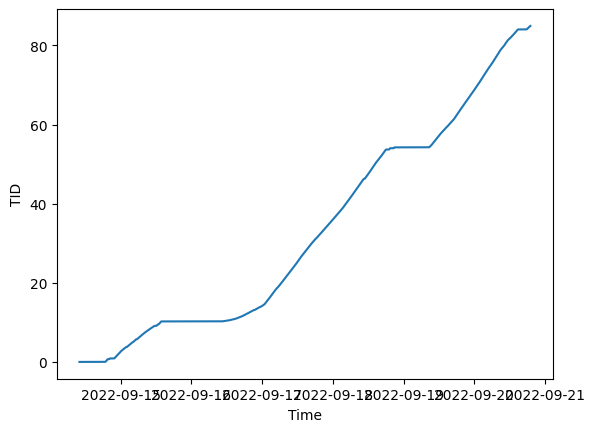

In [6]:
plt.plot(df_run["Time"], df_run["TID"], label="TID")
plt.ylabel("TID")
plt.xlabel("Time")

In [7]:
# df con columnas Time, TID, HEH, N1MeV
df = df_run.sort_values('Time')
df['dt']        = df['Time'].diff().dt.total_seconds()
df['dTID']      = df['TID'].diff()
df['dHEH']      = df['HEH'].diff()
df['dN1MeV']    = df['N1MeV'].diff()
df['TID_dose_rate'] = df['dTID'] / df['dt']
df['N1MeV_dose_rate'] = df['dN1MeV'] / df['dt']
df['HEH_dose_rate'] = df['dHEH'] / df['dt']


# podria quedar radiacion en el material y seguir recibiendo a TID?
# por ello usare mientras esta definicion de beam apagado

Q1 = df['dTID'].quantile(0.25)
Q3 = df['dTID'].quantile(0.75)
IQR = Q3 - Q1
IQR

TID_treshold = Q1 - 1.5 * IQR
print(TID_treshold)

# detecta beam on/off # alternativo un valor chico
# https://cds.cern.ch/record/2745530/files/untitled.pdf
# esto es alrededor de 10 muSv/h
# convirtiendo 1 Sv -> 1 Gy
# lo que se convierte a 1e-7, 1e-8 Gy/s
# epsilon = 1e-7  # Gy/s
epsilon = 1e-5

df['beam_on'] = df['TID_dose_rate'] > epsilon
# porcentaje ON
percentage_on = (df['TID_dose_rate'] > epsilon).mean()
print("Percentage of Beam ON", percentage_on)

# filtra periodos on
on = df[df['beam_on']]

# total tiempo on y conteos on
T_on       = on['dt'].sum()
HEH_on     = on['dHEH'].sum()
N1MeV_on   = on['dN1MeV'].sum()

# flujos medios
flux_HEH   = HEH_on   / T_on   # hadrones/s
flux_N1MeV = N1MeV_on / T_on   # neutrones/s

print(flux_HEH, "hadrons/sec")
print(flux_N1MeV, "neutrons/sec")

-0.022056234261070156
Percentage of Beam ON 0.6636663666366637
544423.3458898435 hadrons/sec
3055165.2101150216 neutrons/sec


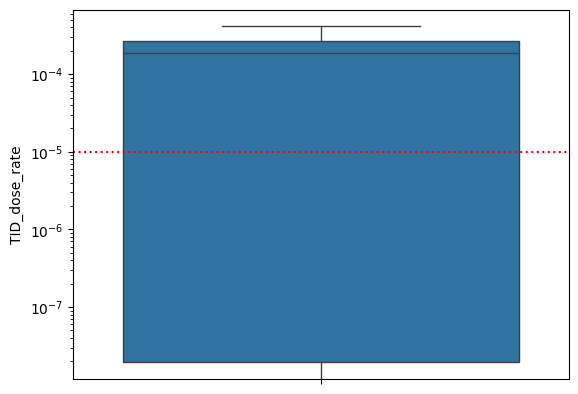

In [8]:
# sin embargo viendo que hay una poblacion separada
# espero que aquello sea un indicativo

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Dibujar el boxplot
sns.boxplot(y=df['TID_dose_rate'])

# 2. Escala logarítmica en el eje Y
plt.yscale('log')

# 3. Añadir línea horizontal en y = 1e-6, roja y punteada
plt.axhline(
    y=epsilon,
    color='red',
    linestyle=':',   # ':' es línea punteada
    linewidth=1.5    # grosor de línea
)

# 4. Mostrar la gráfica
plt.show()


array([[<Axes: title={'center': 'TID_dose_rate'}>]], dtype=object)

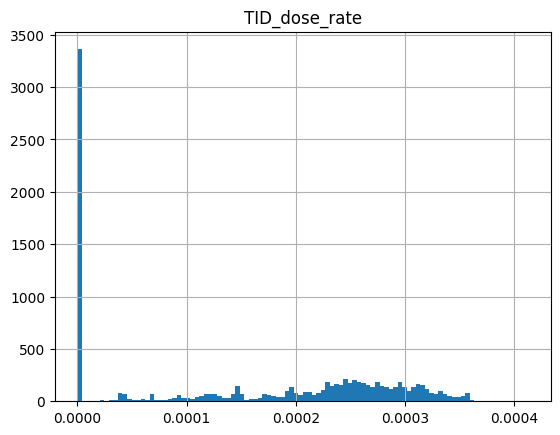

In [9]:
df.hist(bins=100, column='TID_dose_rate')